# Basics

This tutorial gives a brief introduction to the standard pipeline followed optimizing some objective function in CIFY.
First, we'll import CIFY and set a seed for stochastic operations.

In [1]:
import cify as ci

ci.set_seed(0)

CIFY: internal seed successfully set to: '0'


## 1. Objective Function

Everything pipeline starts with defining an objective function. In CIFY, defining an objective function is taken care of by the `ObjectiveFunction` class. We could also define a multi-/many- objective function using the `MultiObjectiveFunction` class.
The `MultiObjectiveFunction` class essentially acts as a wrapper class for the `ObjectiveFunction` class. Since this tutorial is only on the basics, we'll optimize a single objective function. There are two approaches to defining an `ObjectiveFunction`.

1. Using the `get_objective_function` utility method.
2. Manually defining an objective function using the `ObjectiveFunction` class.

The `get_objective_function` utility method takes four parameters, of which only the first is necessary.

1. `func_name` - The name of the benchmark objective function you wish to have returned.
2. `optimization` - The optimization type, (`cify.Optimization.Min` or `cify.Optimization.Max`). This parameter defaults to minimization.
3. `n_dimensions` - The number of dimensions for the objective function. This parameter defaults to 10.
4. `vector_constraints` - An optional list of functions that take a vector as their parameter. For more detail consult The Custom Components Reference tutorial.

For the second approach, we first define the function that takes a vector as its parameter, then we define the `ObjectiveFunction`.
`ObjectiveFunction` takes a number of parameters, we'll only worry about four of them for now.

1. `function` - The function that returns the value to optimize.
2. `optimization` - The same as above
3. `n_dimensions` - The same as above.
4. `bounds` - The upper and lower bounds of the objective function. This may be supplied in a number of different ways, consult the API reference documentation for `ObjectiveFunction` to find out more.

In [2]:
# Approach 1
obj_func = ci.get_objective_function('sphere')

# Approach 2
def func_to_optimize(vector):
    # Return the result of the function.
    return abs(sum(vector))

custom_obj_func = ci.ObjectiveFunction(function=func_to_optimize,
                                       optimization=ci.Optimization.Min,
                                       n_dimensions=10,
                                       bounds=[-10, 10])

## 2. The Metaheuristic / Algorithm

The second step is to define an algorithm, otherwise known as a metaheuristic, that will attempt to solve the previously defined `ObjectiveFunction`.
For this tutorial, we will use a the `InertiaWeightPSO` class. This is a simple PSO algorithm that has an inertia component as well as cognitive and social components.

Metaheuristics are stored in their respective packages and must be imported manually. There are currently two main packages that house metaheuristics:

1. `si` - Swarm Intelligence
2. `ec` - Evolutionary Computation

These two packages make up a wide range of algorithms each with their own search characteristics. Components, otherwise referred to as operators, for all these algorithms are provided and you can easily define your own
implementations. We will only customize the parameters of the velocity update operator in this tutorial. It is worth looking at some of the other tutorials, in particular, the tutorial on algorithms, as well as the API reference documentation
to learn more about how to customize the behaviours of algorithms.

In [3]:
from cify.si.pso.algorithm import InertiaWeightPSO

pso = InertiaWeightPSO(obj_func, swarms=[ci.get_swarm(50, obj_func)])

You may have noticed the use of the `get_swarm` method. This is what's referred to as a utility method. Many utility methods exists and are always kept in a `utils` module in each paradigm. There is also a `utils` module for the `core` package that
contains general utility methods, such as, `get_objective_function` or `get_position_vector`. Now that we have an `ObjectiveFunction` and metaheuristic defined, let's execute the algorithm and take a look at its results.
There are two ways to execute an algorithm, using either the `execute` method or the `iterate` method. Both take the same parameters.

1. `n_iterations` - The maximum number of iterations to perform.
2. `n_evaluations` - The maximum number of objective function evaluations allowed.
3. `stopping_condition` - An optional function that returns a boolean when the algorithm must be stopped.
4. `log` - Whether to print out additional statistics at the end of each iteration.

The `execute` method is simply a wrapper of the `iterate` method, so that all algorithms are linguistically similar to the `Runner` and `Task` classes. But, more on that later.

In [4]:
pso.execute(50)

100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Once the algorithm has finished executing, we can take a look at the results stored in the `statistics` variable. The `statistics` variable, conveniently, is a Pandas DataFrame.
If we wanted to, we could add additional columns to the `statistics` DataFrame by using the algorithm's `add_stats_columns` method'.
This method takes a single string or list of strings representing the column name / names. Each column must be a valid attribute of the algorithm object.
We'll first start by examining the last five iterations.

In [5]:
pso.statistics.tail(5)

,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
46,0.031225,130.434857,48.854003,46.573580,0.017161,5508
47,0.018963,156.629038,49.556076,48.557763,0.017161,5507
48,0.013211,146.943548,51.456730,47.817443,0.013211,5501
49,0.016100,138.992332,53.550162,51.682439,0.013211,5502
50,0.013181,132.117548,49.539194,46.193534,0.013181,5509


As we can see, our algorithm achieved a decent solution, however, it was still far from converging. With some control parameter tuning (for example, tuning the velocity update acceleration coefficients) we should be able to improve upon those results.
Let's plot the global optimum per iteration and see how it changes over time. We'll use matplotlib for to do this.

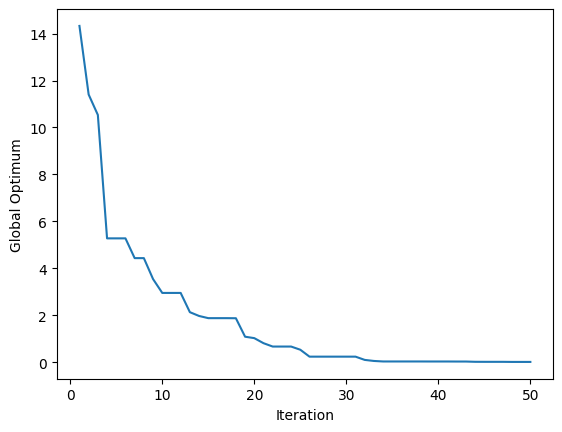

In [6]:
import matplotlib.pyplot as plt

plt.plot(pso.statistics['global_optimum'])
plt.xlabel('Iteration')
plt.ylabel('Global Optimum')
plt.show()

Let's try changing some of the control parameters mentioned previously, and see what effect that has on the global optimum graph. To do this, we just need to pass a `dict` for the `velocity_params` parameter. This same philosophy applies to all metaheuristics and their constituent components. Just check the API reference documentation first to see what parameters you can pass.

If we wanted to change the values and continue iterating from where we were, we can easily do this since the algorithm will pick up where it left off using the new values. Since we want to compare the performance of the new control parameters with the
defaults, we'll define a new algorithm. Only the weight (`w`) and second acceleration coefficient (`c2`) will be changed. `c2` is responsible for the weighting applied to the social component. Hopefully, by increasing this value, we will get earlier convergence.

100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


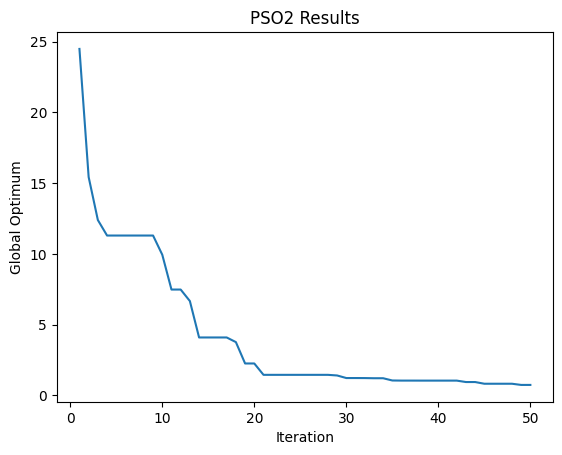

In [14]:
# Define algorithm
pso2 = InertiaWeightPSO(obj_func, swarms=[ci.get_swarm(50, obj_func)],
                        velocity_params={'w': 0.721, 'c2': 1.8})

# Execute
pso2.execute(50)

# Examine results
plt.plot(pso2.statistics['global_optimum'])
plt.title('PSO2 Results')
plt.xlabel('Iteration')
plt.ylabel('Global Optimum')
plt.show()

In [15]:
pso2.statistics.tail(5)

,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
46,0.846522,150.136677,81.434522,36.488143,0.812642,5466
47,0.984588,123.402108,73.246908,30.745832,0.812642,5465
48,0.827567,128.608269,79.231662,30.937904,0.812642,5461
49,0.729024,152.733371,81.040461,35.014592,0.729024,5465
50,0.809018,132.640271,74.800055,33.109720,0.729024,5466


We have successfully managed to reduce the standard deviation of the swarm which indicates an improvement in convergence (exploitative behaviour), however, we have sacrificed the global optimum. Let's compare the convergence between both approaches
by plotting how the standard deviation changes.

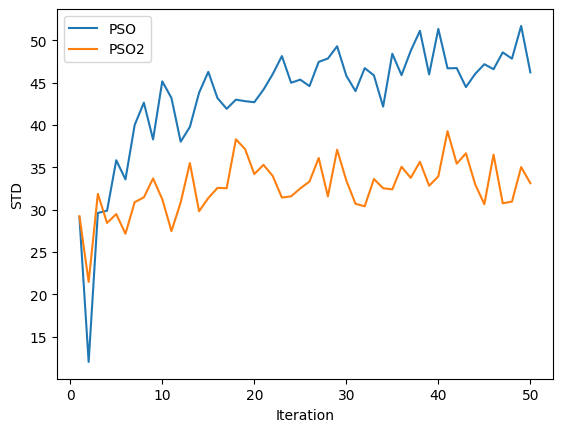

In [18]:
plt.plot(pso.statistics['stdev'], label='PSO')
plt.plot(pso2.statistics['stdev'], label='PSO2')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('STD')
plt.show()

## Conclusion

There are so many possibilities with nature-inspired metaheuristics. In this tutorial, we acquired a benchmark objective function using `get_objective_function`, defined a couple metaheuristics to optimize this function, and compared their performance by examining the resulting `statistics` DataFrame. We only covered a fraction of what CIFY provides so take a look at some of the other tutorials, read through the API reference documentation, or just start experimenting in your favourite development environment.